In [24]:
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely.geometry import LineString
import pickle

# To do (10/5-2023):

- [ ] Color code which part are bike lanes or not. 
- [ ] Look at the top 100 road-parts if they are bikelanes or not. 


In [25]:
bike_data = gpd.read_file("../data/data_all_gpd_v4.shp")

## Plotting routes as heatmap

To be able to plot routes, we need to check how many types different paths in the city have been used.

In [26]:
type(bike_data.iloc[0].geometry)

shapely.geometry.linestring.LineString

First we have to split all lines into segments. And count how many of each segment in the data in order to plot a nice heatmap. 

In [27]:
str(LineString([(10.786247, 59.904461), (10.786262, 59.904486)]))

'LINESTRING (10.786247 59.904461, 10.786262 59.904486)'

### Counting segments

In [28]:
from tqdm import tqdm

# Check if there is a segments_counts.pickle file in the data folder.
# If there is, load it. If not, create it.
try:
    with open("../data/segments_counts.pickle", "rb") as f:
        segments_counts = pickle.load(f)
        print("Loaded segments_counts from pickle file.")

except FileNotFoundError:

    print("No pickle file found. Creating segments_counts.\n")

    segments_counts = {}
    c = 0

    def segments(curve):
        return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

    with tqdm(total=len(bike_data)) as pbar:
        for i in range(len(bike_data)):

            # Update progress bar
            pbar.update(1)

            # Getting the linestring from geometry.
            line = bike_data.iloc[i].geometry

            # Splitting it into segments
            line_segments = segments(line)

            # For each segment in the line, add the segment to the dict and add count.
            for segment in line_segments:

                # Check if it is in the dict, if not add it.
                if segment not in segments_counts:
                    segments_counts[segment] = 1

                # If it is in the dict, add 1 to the count.
                else:
                    segments_counts[segment] += 1

    # We are saving the counts dict in a pickle file.
    with open("../data/segments_counts.pickle", "wb") as f:
        pickle.dump(segments_counts, f)


Loaded segments_counts from pickle file.


In [29]:
# Lets check if it worked.
segments_counts

{<LINESTRING (10.774 59.915, 10.774 59.915)>: 952,
 <LINESTRING (10.774 59.915, 10.774 59.915)>: 952,
 <LINESTRING (10.774 59.915, 10.774 59.915)>: 537,
 <LINESTRING (10.774 59.915, 10.774 59.915)>: 509,
 <LINESTRING (10.774 59.915, 10.774 59.915)>: 509,
 <LINESTRING (10.774 59.915, 10.774 59.915)>: 509,
 <LINESTRING (10.774 59.915, 10.773 59.915)>: 509,
 <LINESTRING (10.773 59.915, 10.773 59.915)>: 509,
 <LINESTRING (10.773 59.915, 10.773 59.915)>: 509,
 <LINESTRING (10.773 59.915, 10.773 59.915)>: 509,
 <LINESTRING (10.773 59.915, 10.773 59.915)>: 509,
 <LINESTRING (10.773 59.915, 10.773 59.915)>: 489,
 <LINESTRING (10.773 59.915, 10.772 59.916)>: 489,
 <LINESTRING (10.772 59.916, 10.772 59.915)>: 439,
 <LINESTRING (10.772 59.915, 10.772 59.915)>: 439,
 <LINESTRING (10.772 59.915, 10.77 59.915)>: 439,
 <LINESTRING (10.77 59.915, 10.77 59.915)>: 439,
 <LINESTRING (10.77 59.915, 10.77 59.915)>: 439,
 <LINESTRING (10.77 59.915, 10.77 59.915)>: 439,
 <LINESTRING (10.77 59.915, 10.77 59.9

In [30]:
# Creating a geodataframe with the segments as geometry and the counts as a column.
segments_gdf = gpd.GeoDataFrame.from_dict(segments_counts, orient='index', columns=['count'])
segments_gdf.reset_index(inplace=True)
segments_gdf.rename(columns={'index': 'geometry'}, inplace=True)
segments_gdf.set_geometry(col='geometry', inplace=True)
segments_gdf.set_crs(epsg=4326, inplace=True)

,geometry,count
0,"LINESTRING (10.77395 59.91491, 10.77397 59.91491)",952
1,"LINESTRING (10.77397 59.91491, 10.77410 59.91489)",952
2,"LINESTRING (10.77410 59.91489, 10.77407 59.91485)",537
3,"LINESTRING (10.77407 59.91485, 10.77398 59.91486)",509
4,"LINESTRING (10.77398 59.91486, 10.77371 59.91489)",509
...,...,...
34505,"LINESTRING (10.72961 59.93757, 10.72980 59.93767)",2
34506,"LINESTRING (10.72980 59.93767, 10.72990 59.93777)",2
34507,"LINESTRING (10.72990 59.93777, 10.72998 59.93784)",2
34508,"LINESTRING (10.72998 59.93784, 10.73007 59.93786)",2


In [31]:
# adding a normalized count column.
segments_gdf['count_norm'] = segments_gdf['count'] / segments_gdf['count'].max()

### Creating the heatmap

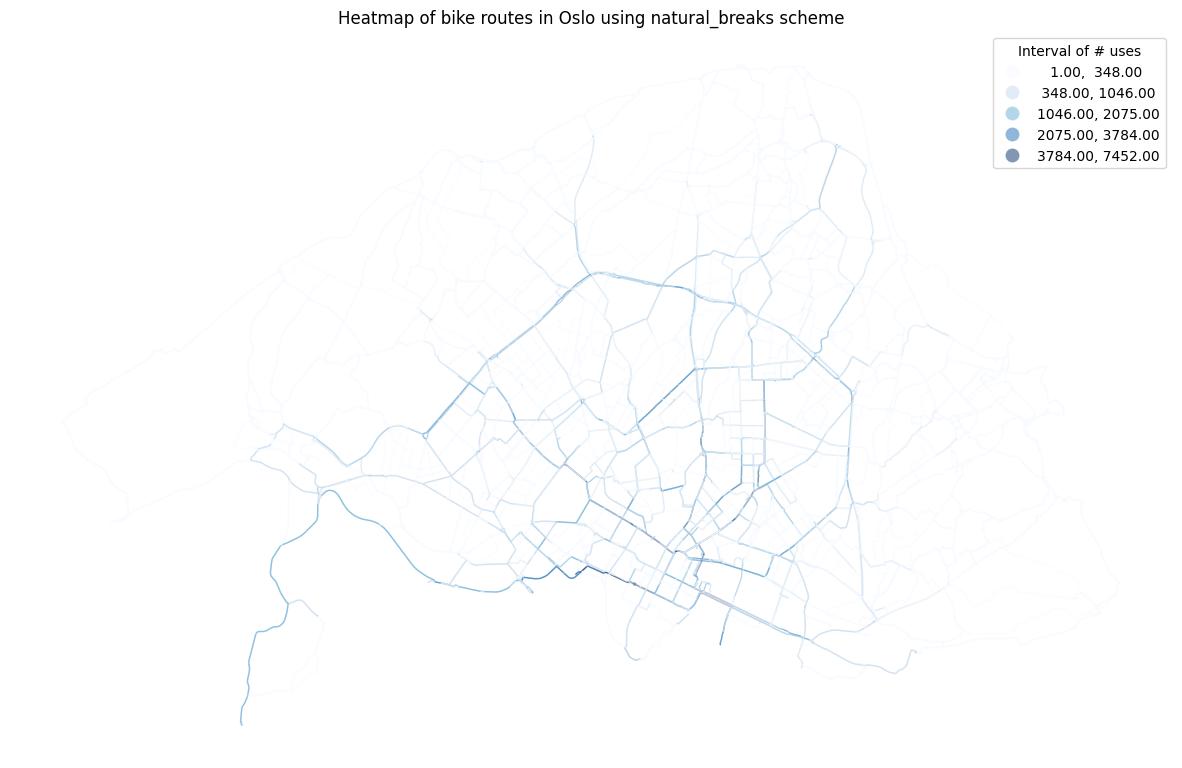

In [32]:
import matplotlib.pyplot as plt

# for scheme in ['quantiles','equal_interval', 'natural_breaks']:
for scheme in ['natural_breaks']:
    # Create heatmap using density_kwds
    ax = segments_gdf.plot(column='count', cmap='Blues', linewidth=1, alpha=0.5, figsize=(15,15),
                scheme=scheme, legend=True, legend_kwds={'title': 'Interval of # uses'}) # 'OrRd'
    ax.set_title(f'Heatmap of bike routes in Oslo using {scheme} scheme')
    
    # remove all axis spines
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # remove all axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # set the background to black
    # ax.set_facecolor('black')

    plt.show()

NameError: name 'Normalize' is not defined

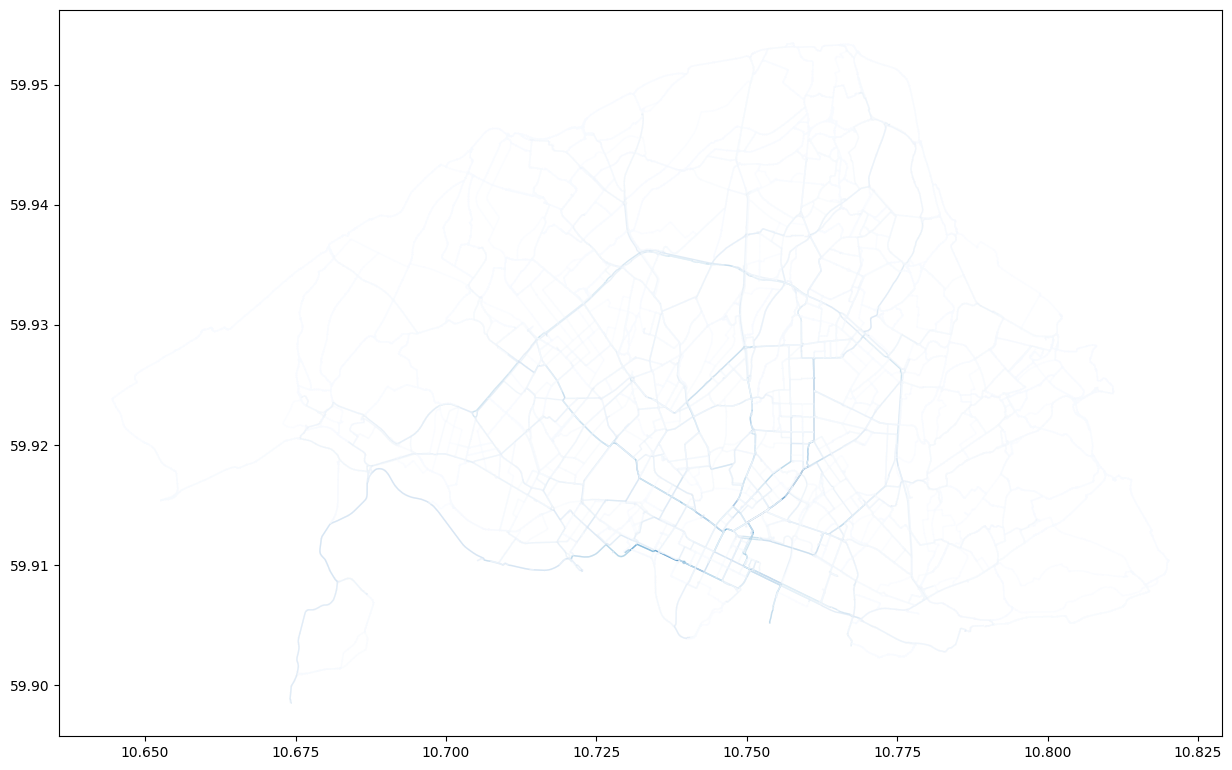

In [33]:
# Set the column to plot and the colormap
column_to_plot = 'count'
cmap = 'Blues'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(15,15))

# Plot the data
segments_gdf.plot(column=column_to_plot, cmap=cmap, linewidth=1, alpha=0.5, ax=ax)

# Create a color bar
vmin = segments_gdf[column_to_plot].min()
vmax = segments_gdf[column_to_plot].max()
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax)

# Remove all axis spines and ticks
ax.axis('off')

# Set the title of the plot
ax.set_title(f'Heatmap of bike routes in Oslo using {cmap} colormap')

# Show the plot
plt.show()